# Vehicle Detection
#### Luke Walker
#### Udacity Self Driving Car Nanodegree P5

### Imports

In [1]:
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Make a list of images to read in

In [2]:
#Vehicle Images
basedir = 'vehicles/'

image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))
    
print ('Number of Vehicle Images Found:', len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')

#Non Vehicle Images
basedir = 'non-vehicles/'

image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))
    
print ('Number of Non Vehicle Images Found:', len(notcars))
with open("notcars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')
        

Number of Vehicle Images Found: 8792
Number of Non Vehicle Images Found: 8968


#### Visualize some of the images

In [3]:
def visualize(fig, rows, cols, imgs, titles):
    """
    Function for plotting multiple images (From project walkthrough)
    """
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

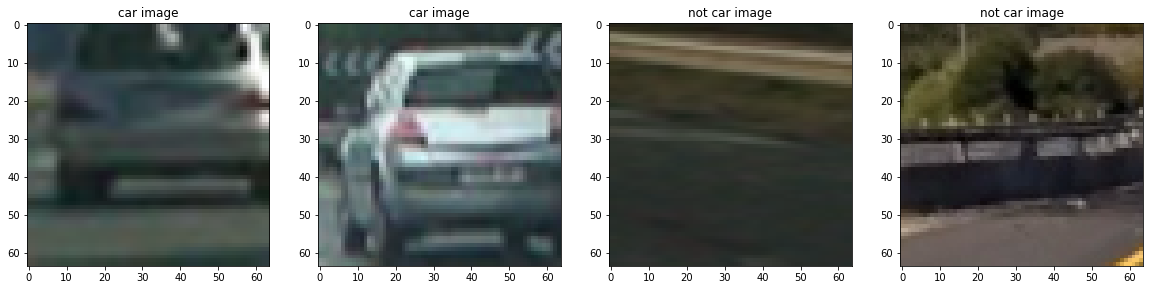

In [4]:
# Get random car and not car indicies
car_ind = np.random.randint(0,len(cars))
car_ind2 = np.random.randint(0,len(cars))
notcar_ind = np.random.randint(0,len(notcars))
notcar_ind2 = np.random.randint(0,len(notcars))

# Read in images
car_img = mpimg.imread(cars[car_ind])
car_img2 = mpimg.imread(cars[car_ind2])
notcar_img = mpimg.imread(notcars[notcar_ind])
notcar_img2 = mpimg.imread(notcars[notcar_ind2])

images = [car_img, car_img2, notcar_img, notcar_img2]
titles = ['car image', 'car image', 'not car image', 'not car image']
fig = plt.figure(figsize=(20,5))
visualize(fig, 1, 4, images, titles)

### Defining Functions
##### Many come directly from the lessons or have been adapted from project walkthrough suggestions

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Calculates the Histogram Orient Gradient (HOG) and returns features.
    If vis == True it also returns an image.
    """
    
    # Return features and Image
    if vis == True:
        features, hog_image = hog(img, orientations = orient,
                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block),
                                 transform_sqrt=False,
                                 visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise only return features
    else:
        features = hog(img, orientations = orient,
                         pixels_per_cell=(pix_per_cell, pix_per_cell),
                         cells_per_block=(cell_per_block, cell_per_block),
                         transform_sqrt=False,
                         visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
def bin_spatial(img, size=(32, 32)):
    """
    Retruns a row vector of the 3 color channels stacked and resized
    """
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [7]:
# Compute color histogram of features
def color_hist(img, nbins=32): #bins_range=(0, 256)
    """
    Returns histogram features
    """
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

In [8]:
def convert_color(img, conv='RGB2YCrCb'):
    """
    Converts RGB to CrCb or LUV and GBR to YCrCb
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [9]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                    hist_bins=32, orient=9,
                    pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extracts the features from a list of images
    """
    # Create a list of features
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in
        image = mpimg.imread(file)
        # Convert color spaces
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RBG2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RBG2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True: 
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)

            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

In [10]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                xy_window=(64, 64), xy_overlap=(0.5,0,5)):
    """
    Sliding window for searching for cars within image
    """
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Span
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Pixels / Step
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    
    # Number of windows
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    # List to append window positions to
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
    # Return Window List
    return window_list

In [11]:
def draw_boxes(img, bboxes, color = (0, 0, 255), thick = 6, random_color = False):
    """
    Draws box on simgle image to see where car was found
    """
    
    # Copy image
    imcopy = np.copy(img)
    
    # Iterate through
    for bbox in bboxes:
        # Random color code copied from jeremy-shannon
        if random_color == True:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [12]:
def single_image_features(img, color_space='RGB', spatial_size=(32,32),
                         hist_bins=32, orient=9,
                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
                         spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    """
    Extract features on single image
    """
    
    # Define list for features
    img_features = []
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        if color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        if color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        if color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        if color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel],
                                          orient, pix_per_cell, cell_per_block,
                                          vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                          orient, pix_per_cell, cell_per_block,
                                          vis=False, feature_vec=True)
            # Append to List
        img_features.append(hog_features)
            
        # Concatenated array of features
        if vis == True:
            return np.concatenate(img_features), hog_image
        else:
            return np.concatenate(img_features)

In [13]:
def search_windows(img, windows, clf, scaler, color_space ='RGB',
                  spatial_size=(32, 32), hist_bins=32,
                  hist_range=(0,256), orient=9,
                  pix_per_cell=8, cell_per_block=2,
                  hog_channel=0, spatial_feat=True,
                  hist_feat=True, hog_feat=True):
    """
    Creates windows to search in
    """
    
    # Create empty list
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_image_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

#### Test Sliding Window Implementation

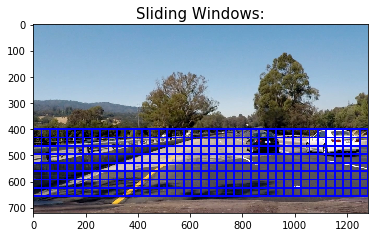

In [28]:
test_img = mpimg.imread('test_images/test4.jpg')

windows =  slide_window(test_img,
                        x_start_stop=[None, None],
                        y_start_stop=[400, 656], #tune the parameters
                        xy_window=(64, 64),
                        xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_img, windows, random_color=False)
plt.imshow(window_img);
plt.title('Sliding Windows:', fontsize=15);
plt.savefig('output_images/sliding_windows.png', bbox_inches="tight")

#### Visualize HOG on Random Car, and Not Car with Image Shown

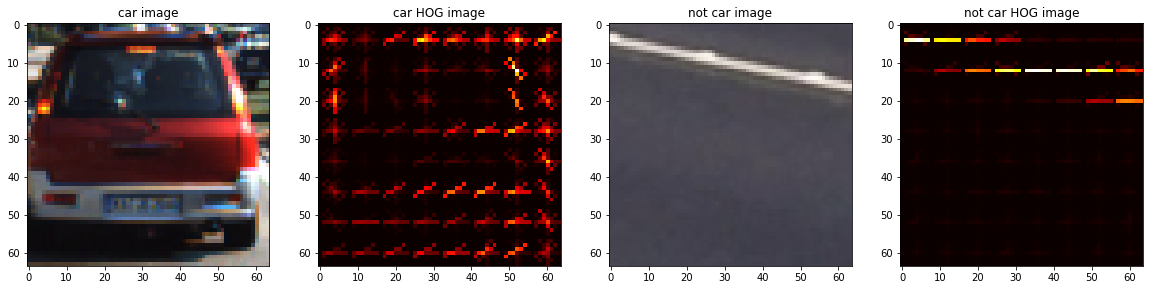

In [15]:
# Get random car and not car indicies
car_ind = np.random.randint(0,len(cars))
notcar_ind = np.random.randint(0,len(notcars))

# Read in images
car_img = mpimg.imread(cars[car_ind])
notcar_img = mpimg.imread(notcars[notcar_ind])

# Define features
color_space = 'RGB'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 #0,1,2, 'ALL'
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_image_features(car_img, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                                 hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
notcar_features, notcar_hog_image = single_image_features(notcar_img, color_space=color_space, spatial_size=spatial_size,
                                                 hist_bins=hist_bins, orient=orient,
                                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                                 hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [car_img, car_hog_image, notcar_img, notcar_hog_image]
titles = ['car image', 'car HOG image', 'not car image', 'not car HOG image']
fig = plt.figure(figsize=(20,5))
visualize(fig, 1, 4, images, titles)

#### Train SVC

In [16]:
# Define features
color_space = 'YCrCb' #YCrCb #RGB
orient = 9 #6 Based on paper
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' #'ALL' # 0
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
n_samples = 1000

#randomize dataset
random_idxs = np.random.randint(0,len(cars), n_samples)
test_cars = cars #np.array(cars)[random_idxs] #cars
test_notcars = notcars #np.array(notcars)[random_idxs] #notcars

car_features = extract_features(test_cars, color_space=color_space,
                               spatial_size=spatial_size, hist_bins=hist_bins,
                               orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block,
                               hog_channel=hog_channel, spatial_feat=spatial_feat,
                               hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space,
                               spatial_size=spatial_size, hist_bins=hist_bins,
                               orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block,
                               hog_channel=hog_channel, spatial_feat=spatial_feat,
                               hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Scale X
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Labels
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#Randomize
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using: ', orient, 'orientations,', pix_per_cell,
      'Pixels per cell,', cell_per_block, 'cells per block,',
      hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:' ,len(X_train[0]))

# Using a linear SVC from recommendations on tips and tricks
svc = LinearSVC()

t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


115.11777591705322 Seconds to compute features...
Using:  9 orientations, 8 Pixels per cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
48.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


#### Test accuracy using Linear SVC and YCrCb color space

0.0 1.0
1.0034699440002441 seconds to process one image searching 100 windows
0.0 1.0
0.6585788726806641 seconds to process one image searching 100 windows
0.0 1.0
0.5990397930145264 seconds to process one image searching 100 windows
0.0 1.0
0.6339511871337891 seconds to process one image searching 100 windows
0.0 1.0
0.6051678657531738 seconds to process one image searching 100 windows
0.0 1.0
0.5898821353912354 seconds to process one image searching 100 windows


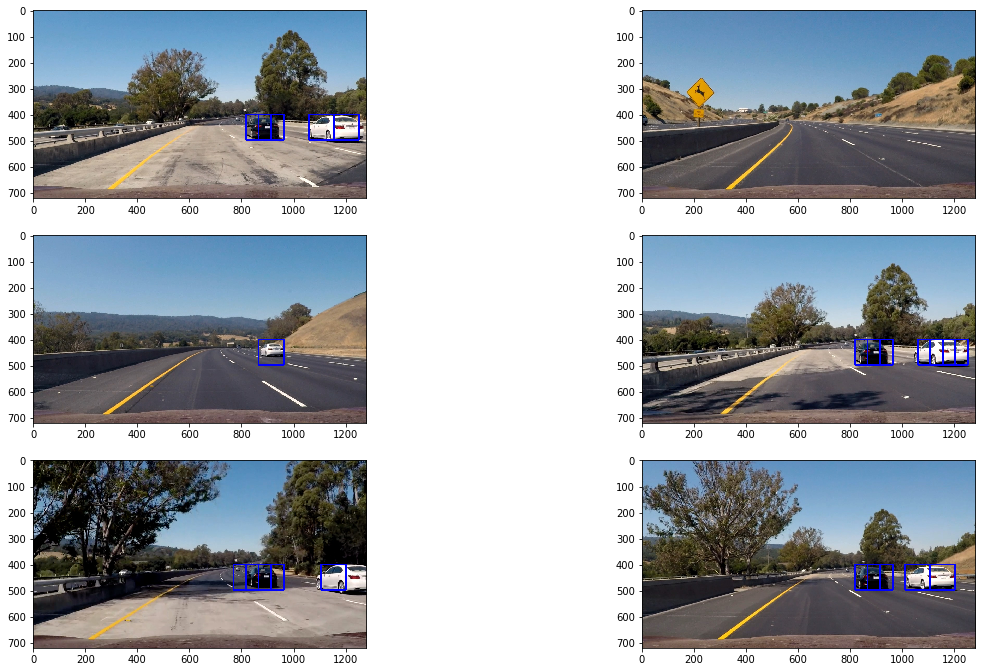

In [17]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656]
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255 #Scaling image because training with PNG and now reading in JPG
    print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window=(96, 96), xy_overlap=(overlap, overlap))
    ## Maybe 64,64, and 128,128
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')

fig = plt.figure(figsize=(20,20))
visualize(fig, 5, 2, images, titles)


#### Caluculate hog for entire image and then check

0.6248610019683838 seconds to run, total windows =  294
0.5296759605407715 seconds to run, total windows =  294
0.48276305198669434 seconds to run, total windows =  294
0.49715399742126465 seconds to run, total windows =  294
0.5063989162445068 seconds to run, total windows =  294
0.4591529369354248 seconds to run, total windows =  294


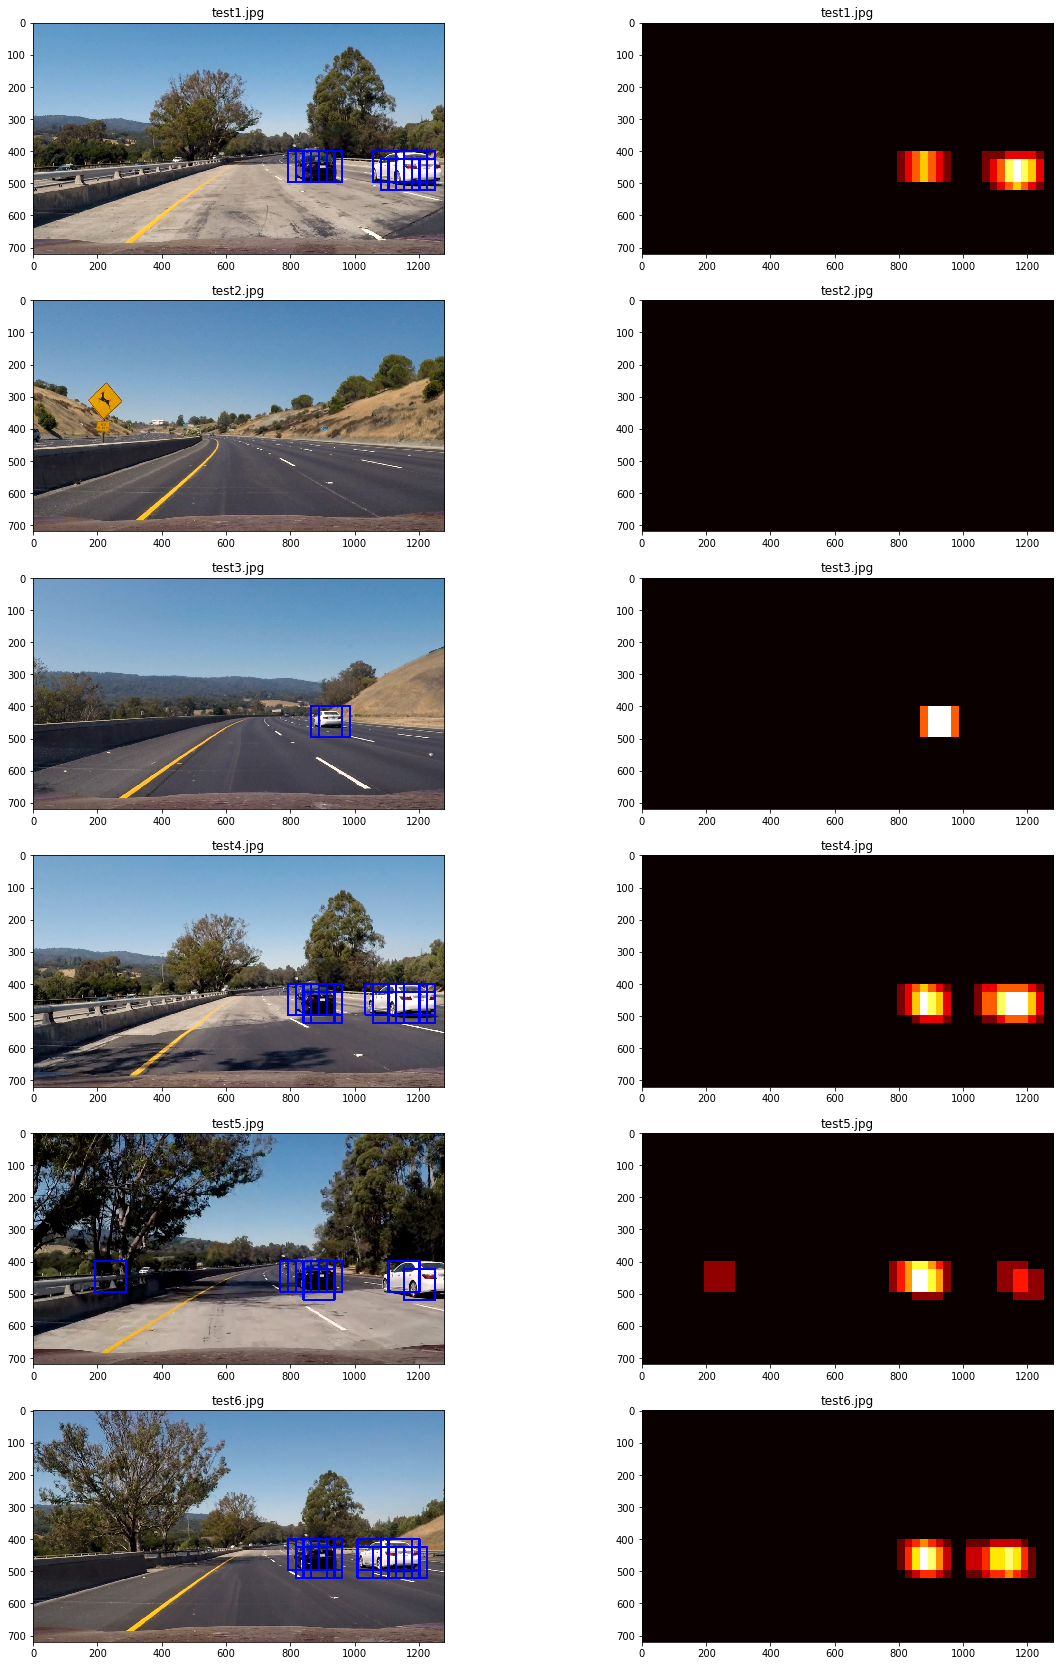

In [18]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop = 656
scale = 1.5 #1.5 Allows sampling at different image size

for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_toserach = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_toserach, conv='RGB2YCrCb')
    
    if scale !=1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, ((np.int(imshape[1]/scale)), np.int(imshape[0]/scale)))
        
    #Make extracting channels a function!
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_bloc = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute HOG on channels
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255), 6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
        
    print(time.time()-t, 'seconds to run, total windows = ', count)

    out_images.append(draw_img)

    out_titles.append(img_src[-9:])
    out_titles.append(img_src[-9:])

    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

fig = plt.figure(figsize=(20, 40))
visualize(fig, 8 ,2, out_images, out_titles)
    

In [19]:
def find_cars(img, scale):
    """
    Finds cars in images and applys heat map
    """
    
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute HOG on channels
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    
    return draw_img, heatmap

In [20]:
def apply_threshold(heatmap, threshold):
    """
    Applys a heatmap threshold
    """
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [21]:
def draw_labeled_bboxes(img, labels):
    """
    Draws labeled bounding boxes
    """
    for car_number in range(1, labels[1]+1):
        
        nonzero = (labels[0] == car_number).nonzero()
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img


In [29]:
out_images = []
out_maps = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    
#fig = plt.figure(figsize=(20, 40))
#visualize(fig, 8, 2, out_images, out_titles)

In [23]:
def process_img(img):
    
    out_img, heat_map = find_cars(img, scale)
    labels = label(apply_threshold(heat_map, .8))
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [24]:
test_output = "test_output.mp4"
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(process_img)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [00:17<00:00,  2.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 16.5 s, sys: 780 ms, total: 17.3 s
Wall time: 19 s


In [25]:
HTML("""
<video width="960" height="580" controls>
    <source src="{0}">
</video>
""".format(test_output))

In [26]:
output = "project_video_output.mp4"
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_img)
%time test_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [08:57<00:00,  2.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 26s, sys: 21.4 s, total: 8min 47s
Wall time: 8min 58s


In [27]:
HTML("""
<video width="960" height="580" controls>
    <source src="{0}">
</video>
""".format(output))